## Load data, balance classes and save

In [1]:
import sys
sys.path.append("../utils/.")

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# tf.random.set_random_seed(13)

from utils import *


In [3]:
data_path = '../data/acc/compressed/full_data.npy'
save_path = "../data/minute_norm_acc/"


STEP = 1
future_target = 10
past_history = 15


## The Ridgecrest Dataset
This notebook uses a earthquake dataset from Ridgecrest, collected from July to September of 2019.
There are several thousand earthquakes during this time period, which were collected at anywhere from 16-30 stations.

In [4]:
#Swap axes
dataset = np.load(data_path)
print("Before: ", dataset.shape)

dataset = dataset.swapaxes(1, -1)

TRAIN_SPLIT_IDX = int(dataset.shape[0]*0.8)


#Combine station and xyz
#dataset = dataset.reshape(dataset.shape[0], dataset.shape[1], -1)
print("After: ", dataset.shape)

Before:  (35679, 15, 60)
After:  (35679, 60, 15)


35679
-0.49 7.1
35679
0.0 3.0
[8.31445749e-01 3.72105878e-01 9.15785421e+00 1.48662500e+03]
[2.000e+00 1.000e+00 1.000e+01 1.488e+03]


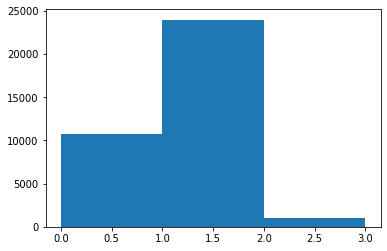

In [5]:
from sklearn.utils.class_weight import compute_class_weight

richters_path = "../data/metadata/richters.npy"
richters = np.load(richters_path)
print(len(richters))
print(min(richters), max(richters))

classes = [0, 1, 2, 3]
richters_discrete = np.zeros_like(richters)
richters_discrete += np.where(richters >= 5., np.ones_like(richters), np.zeros_like(richters))
richters_discrete += np.where(richters >= 3., np.ones_like(richters), np.zeros_like(richters))
richters_discrete += np.where(richters >= 1., np.ones_like(richters), np.zeros_like(richters))
# richters_discrete += np.where(richters < 1., np.ones_like(richters), np.zeros_like(richters))

print(len(richters_discrete))
print(min(richters_discrete), max(richters_discrete))

class_weights = compute_class_weight('balanced', np.array(classes), richters_discrete)
print(class_weights)
# num_copies = np.round(class_weights, 0) + 1 #Add constant to ensure minimum num copies for smallest class
num_copies = np.round(class_weights, 0) + 1 #Add constant to ensure minimum num copies for smallest class

print(num_copies)
plt.hist(richters_discrete, bins=3)
plt.show()

# Normalization over whole quake

In [6]:
# data_mean = np.mean(dataset, axis = 1)
# data_var = np.linalg.norm(dataset - np.expand_dims(data_mean, 1), axis = 1)



# #Add some epsilon to make the divide by zero var work
# epsilon = 1
# data_var[data_var == 0] = epsilon

# dataset = (dataset - np.expand_dims(data_mean, 1))/np.expand_dims(data_var, 1)

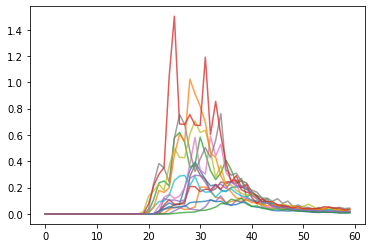

In [7]:
test_idx = 251

for i in range(15):
    plt.plot(dataset[test_idx, :, i], alpha=0.75)
    
plt.show()

An observation is recorded every centisecond. This means that, for a single minute, you will have 60000 observations. 

Given a specific sequence, let's say you want to predict the future shaking of the earthquake at the next time point. In order to make this prediction, you choose to use 10 seconds of observations. Thus, you would create a window containing the last 1000 observations to train the model..

In [6]:
from sklearn.model_selection import train_test_split

dataset, richters_discrete = shuffle_together(dataset, richters_discrete, seed=10)

In [7]:
train_distrib = list([int(np.sum(richters_discrete[:TRAIN_SPLIT_IDX] == i)) for i in range(4)])
val_distrib = list([int(np.sum(richters_discrete[TRAIN_SPLIT_IDX:] == i)) for i in range(4)])
print("Distribution of discrete richter magnitudes (<1, 1-3, 3-5, >=5):")
print("Train set: ", train_distrib)
print("Val set: ", val_distrib)


Distribution of discrete richter magnitudes (<1, 1-3, 3-5, >=5):
Train set:  [8560, 19193, 786, 4]
Val set:  [2168, 4778, 188, 2]


### Multi-step predictions

In [8]:
x_train_single, y_train_single = multivariate_data_balanced(dataset[:TRAIN_SPLIT_IDX],past_history,
                                                   future_target, STEP,
                                               richters_discrete[:TRAIN_SPLIT_IDX], num_copies,
                                                   single_step=False)
x_val_single, y_val_single = multivariate_data(dataset[TRAIN_SPLIT_IDX:], past_history,
                                               future_target, STEP,
#                                                richters_discrete[TRAIN_SPLIT_IDX:], num_copies,
                                               single_step=False)


# print(y_single.shape, x_single.shape)
# x_train_single, x_val_single, y_train_single, y_val_single = train_test_split(x_single, y_single, test_size=.2, random_state=13)
print(x_train_single.shape, x_val_single.shape, y_train_single.shape, y_val_single.shape)

(1754375, 15, 15) (249760, 15, 15) (1754375, 10, 15) (249760, 10, 15)


## Normalizing over windows

In [9]:
"""
Normalizing using 15-sec history
"""
# for i in range(x_train_single.shape[0]):
data_mean_train = np.mean(x_train_single, axis = 1, keepdims=True)
data_var_train = np.linalg.norm(x_train_single - data_mean_train, axis=1, keepdims=True)
data_var_train[data_var_train==0] = 1

x_train_single = (x_train_single - data_mean_train)/data_var_train
y_train_single = (y_train_single - data_mean_train)/data_var_train

# for i in range(x_val_single.shape[0]):
data_mean_val = np.mean(x_val_single, axis = 1, keepdims=True)
data_var_val = np.linalg.norm(x_val_single - data_mean_val, axis=1, keepdims=True)
data_var_val[data_var_val==0] = 1

x_val_single = (x_val_single - data_mean_val)/data_var_val
y_val_single = (y_val_single - data_mean_val)/data_var_val

In [10]:
x_train_single.shape, y_train_single.shape, x_val_single.shape, y_val_single.shape

((1754375, 15, 15), (1754375, 10, 15), (249760, 15, 15), (249760, 10, 15))

In [11]:
# np.save(os.path.join(save_path, "X_train.npy"), x_train_single)
# np.save(os.path.join(save_path, "y_train.npy"), y_train_single)
# np.save(os.path.join(save_path, "X_val.npy"), x_val_single)
# np.save(os.path.join(save_path, "y_val.npy"), y_val_single)

np.save(os.path.join(save_path, "X_train_new.npy"), x_train_single)
np.save(os.path.join(save_path, "y_train_new.npy"), y_train_single)
np.save(os.path.join(save_path, "X_val_new.npy"), x_val_single)
np.save(os.path.join(save_path, "y_val_new.npy"), y_val_single)

np.save(os.path.join(save_path, "richters_discrete.npy"), richters_discrete)

np.save(os.path.join(save_path, "mean_train.npy"), data_mean_train)
np.save(os.path.join(save_path, "var_train.npy"), data_var_train)
np.save(os.path.join(save_path, "mean_val.npy"), data_mean_val)
np.save(os.path.join(save_path, "var_val.npy"), data_var_val)

In [ ]:
np.save(os.path.join(save_path, "X_train_new.npy"), x_train_single)
np.save(os.path.join(save_path, "y_train_new.npy"), y_train_single)
np.save(os.path.join(save_path, "X_val_new.npy"), x_val_single)
np.save(os.path.join(save_path, "y_val_new.npy"), y_val_single)


In [12]:
import json

config = dict(zip(["data_path", "past_history", "STEP", "future_target", "train_distrib", "val_distrib", ], \
                  [data_path, past_history, STEP, future_target, train_distrib, val_distrib]))

with open(os.path.join(save_path, "config.json"), 'w') as json_file:
    json.dump(config, json_file)

In [12]:
# Save unscaled inputs

x_train_original, y_train_original = multivariate_data_balanced(dataset[:TRAIN_SPLIT_IDX],past_history,
                                                   future_target, STEP,
                                               richters_discrete[:TRAIN_SPLIT_IDX], num_copies,
                                                   single_step=False)
x_val_original, y_val_original = multivariate_data(dataset[TRAIN_SPLIT_IDX:], past_history,
                                               future_target, STEP,
#                                                richters_discrete[TRAIN_SPLIT_IDX:], num_copies,
                                               single_step=False)

np.save(os.path.join(save_path, "X_train_original.npy"), x_train_original)
np.save(os.path.join(save_path, "y_train_original.npy"), y_train_original)
np.save(os.path.join(save_path, "X_val_original.npy"), x_val_original)
np.save(os.path.join(save_path, "y_val_original.npy"), y_val_original)